<a href="https://colab.research.google.com/github/ThuongNguyen168/To-do-list-with-Face-Verification/blob/main/Face_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1365967%2F2415961%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240221%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240221T045353Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da1ca83b0b1ca76d70667d1744810737ef8faad76839f1b622023a4803f6aee93721a3b0a4816e930ebfc60b9b6bf6ae5c37f455bcf2c36e30447821332562cb7fa8bfc795a0b961ee32cc3a711b2ea38bbd8b9a900dda76ecb16904f94a45ffb128162fdd9f97eba12764af0e2f3cc5d7b7bfb47171d6f4787b0626cf252240e4ad851e3c8709844fcd2348dffdd640889e6bd824428dddef694317292eab159c925627f59a9477b3195acb60e6decd384f428e711ed77e4045ba678fc9c5b94ab6161c3437c99aad690883675551a255cb55846fbd8fecaeeddd7dd1a2224235608b293f671f5a5716d5afde2a9edac22c7f7bf6640e9d41b698579462b16e4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


### Import Library

In [ ]:
!pip install git+https://github.com/yaledhlab/vggface.git -q
!pip install keras_applications -q

import os
import cv2
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras_vggface.vggface import VGGFace

from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.spatial import distance

### Reading the dataset

In [ ]:
ROOT = "/kaggle/input/face-recognition-dataset/Extracted Faces/Extracted Faces"

# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [ ]:
def split_dataset(directory, split=0.85):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.85)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1125
Length of testing list : 199

Test List: {'179': 2, '1015': 3, '1153': 3, '1221': 4, '677': 2, '596': 2, '1081': 3, '1229': 3, '1097': 6, '708': 17, '313': 3, '789': 2, '1119': 2, '78': 2, '890': 5, '1006': 10, '106': 3, '264': 2, '1504': 2, '1617': 2, '1088': 14, '765': 3, '936': 2, '1047': 2, '1148': 2, '1455': 2, '85': 4, '784': 14, '914': 2, '825': 4, '353': 5, '938': 2, '1226': 2, '21': 3, '436': 2, '60': 33, '862': 8, '1337': 5, '839': 2, '1514': 2, '1625': 2, '386': 6, '56': 2, '822': 2, '122': 4, '923': 4, '1100': 2, '560': 3, '920': 5, '1340': 2, '933': 4, '462': 2, '25': 2, '597': 2, '800': 14, '1423': 19, '1018': 4, '1180': 3, '346': 4, '1607': 2, '1016': 6, '1421': 9, '13': 3, '82': 3, '1102': 2, '995': 2, '323': 2, '1': 2, '1479': 2, '1307': 4, '1588': 46, '1447': 4, '621': 7, '1074': 4, '649': 12, '1487': 4, '616': 13, '1045': 2, '1674': 2, '591': 11, '564': 2, '925': 2, '257': 3, '66': 3, '211': 4, '226': 7, '970': 2, '911': 3, '620': 4, '34

#### Tạo các cặp triplet

In [ ]:
def create_triplets(directory, folder_list, max_files=15):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 13682
Number of testing triplets : 2749

Examples of triplets:
(('1246', '0.jpg'), ('1246', '4.jpg'), ('444', '2.jpg'))
(('900', '8.jpg'), ('900', '9.jpg'), ('657', '0.jpg'))
(('1152', '6.jpg'), ('1152', '10.jpg'), ('1251', '0.jpg'))
(('1402', '0.jpg'), ('1402', '1.jpg'), ('966', '1.jpg'))
(('275', '0.jpg'), ('275', '1.jpg'), ('47', '1.jpg'))


In [ ]:
def get_batch(triplet_list, batch_size=512, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

#### Xuất thử một số ảnh trong data

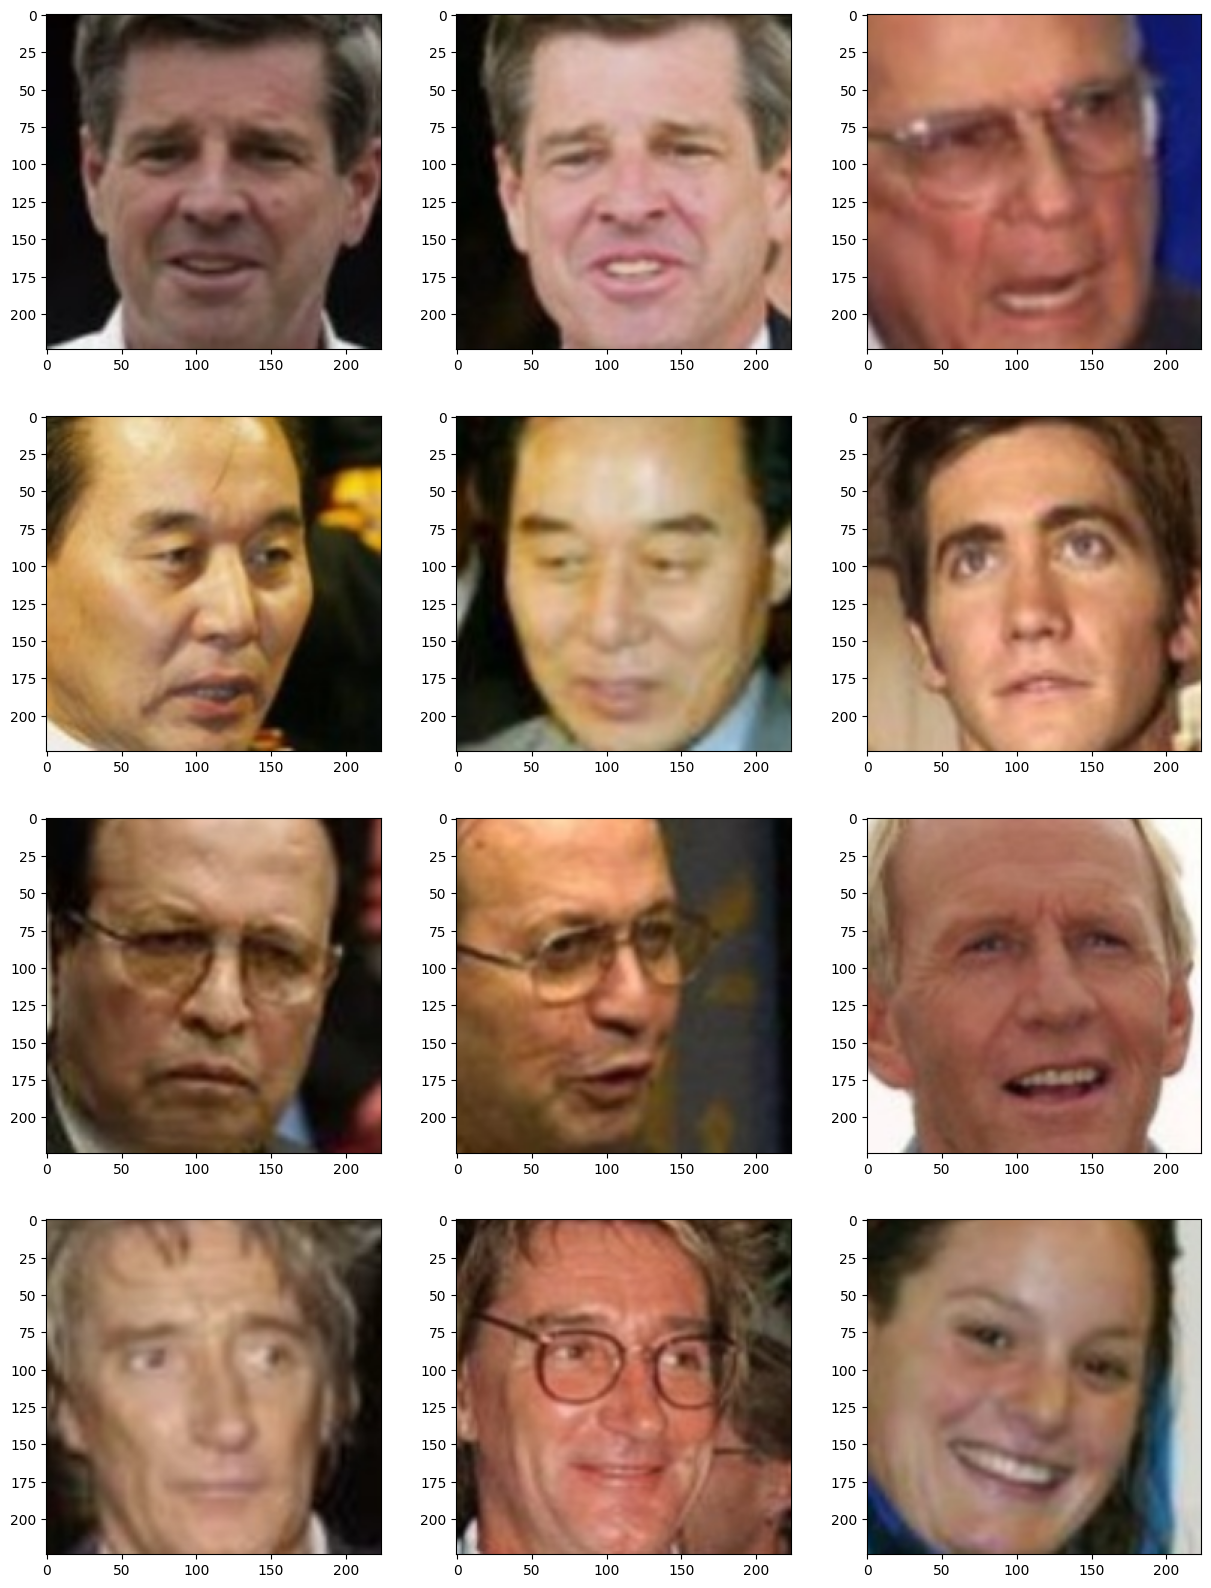

In [ ]:
def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, (224, 224))

f, axes = plt.subplots(4, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=4, preprocess=False):
    a,p,n = x
    for i in range(4):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

### Tạo model

Base Model

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = VGGFace(model='vgg16',include_top=False, input_shape=(224, 224, 3), pooling='avg')
    pretrained_model.trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

Siamese Model

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (224, 224, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()

58916864/58909280 [==============================] - 0s 0us/step


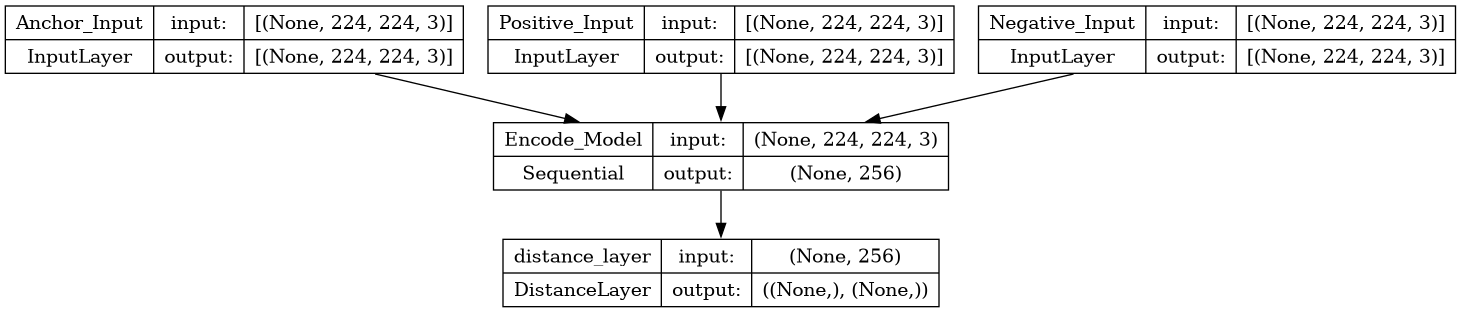

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=0.7):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

siamese_model.compile(optimizer=Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.9, staircase=True), epsilon=1e-01))

### Train và test model

In [ ]:
def test_on_triplets(batch_size = 16):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data, verbose=0)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
save_all = True
epochs = 20
batch_size = 16

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 303 sec)
Loss on train    = 0.07490
Accuracy on test = 0.97563

EPOCH: 2 	 (Epoch done in 276 sec)
Loss on train    = 0.01975
Accuracy on test = 0.97454

EPOCH: 3 	 (Epoch done in 276 sec)
Loss on train    = 0.00840
Accuracy on test = 0.97890

EPOCH: 4 	 (Epoch done in 277 sec)
Loss on train    = 0.00477
Accuracy on test = 0.97599

EPOCH: 5 	 (Epoch done in 280 sec)
Loss on train    = 0.00272
Accuracy on test = 0.98072

EPOCH: 6 	 (Epoch done in 278 sec)
Loss on train    = 0.00182
Accuracy on test = 0.98108

EPOCH: 7 	 (Epoch done in 275 sec)
Loss on train    = 0.00157
Accuracy on test = 0.97781

EPOCH: 8 	 (Epoch done in 275 sec)
Loss on train    = 0.00086
Accuracy on test = 0.97999

EPOCH: 9 	 (Epoch done in 273 sec)
Loss on train    = 0.00055
Accuracy on test = 0.97817

EPOCH: 10 	 (Epoch done in 272 sec)
Loss on train    = 0.00045
Accuracy on test = 0.97636

EPOCH: 11 	 (Epoch done in 270 sec)
Loss on train    = 0.00030
Accuracy on test = 0.98581

EPOCH: 

### Evaluation

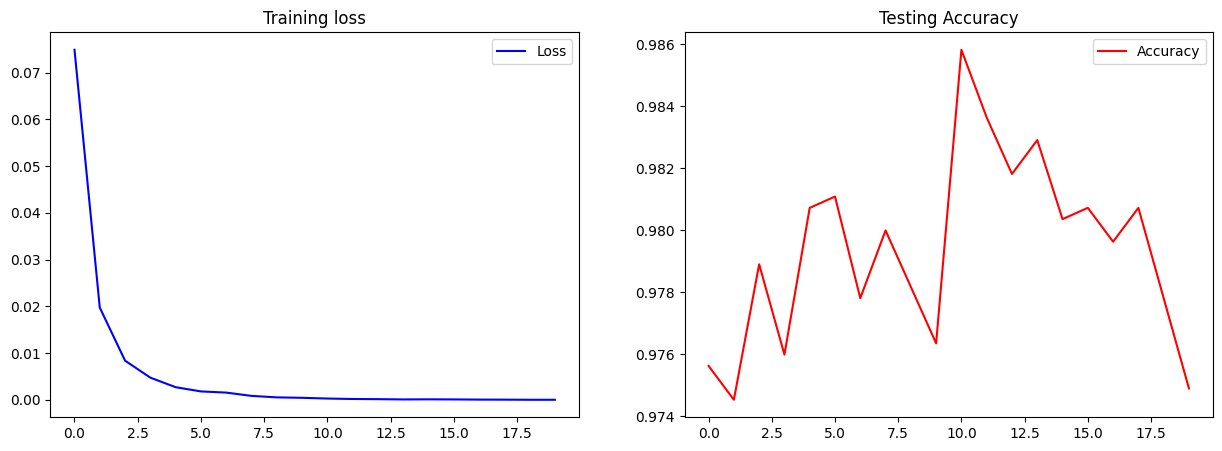

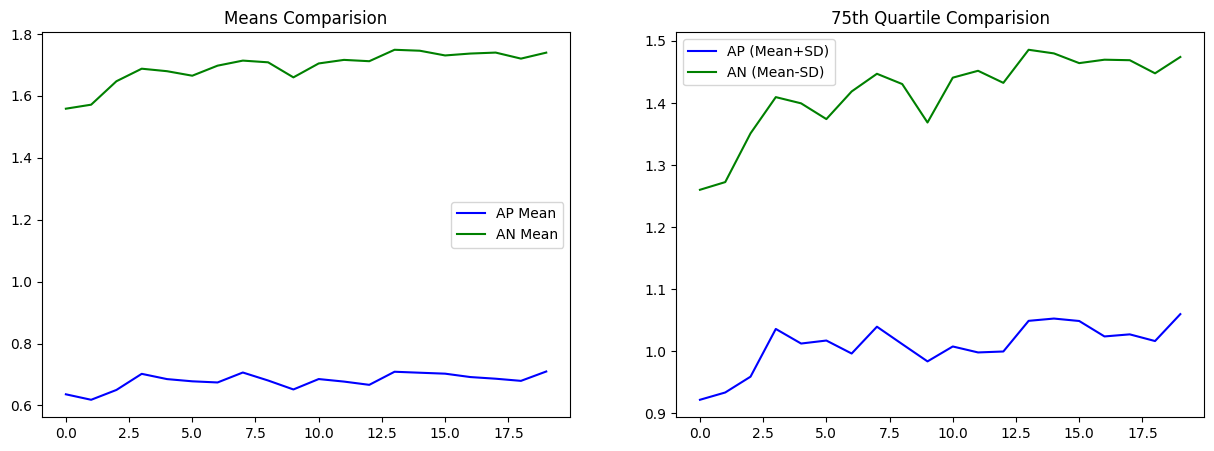

In [ ]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()

    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

### Inference

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((224, 224, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder.h5")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1, verbose=0)
    tensor2 = encoder.predict(face_list2, verbose=0)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.92578125



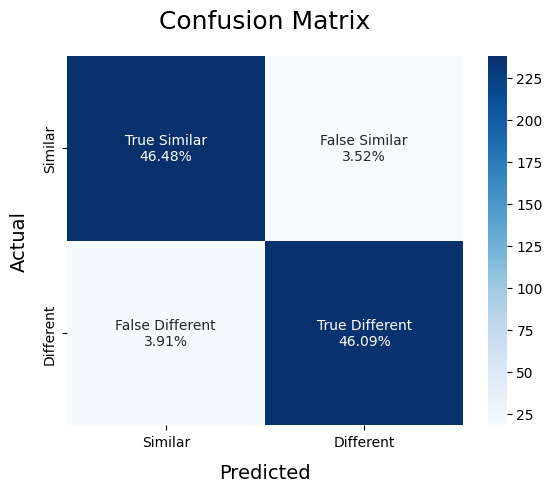

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [ ]:
def classify_image(face_list1, face_list2, threshold=0.25):
    # Getting the encodings for the passed faces
    face_list1 = read_image_from_path(face_list1)
    face_list2 = read_image_from_path(face_list2)

    face_list1 = np.array(face_list1)
    face_list1 = preprocess_input(face_list1)

    face_list2 = np.array(face_list2)
    face_list2 = preprocess_input(face_list2)

    face_list1 = face_list1.reshape(-1,224,224,3)
    face_list2 = face_list2.reshape(-1,224,224,3)

    tensor1 = encoder.predict(face_list1, verbose=0)
    tensor2 = encoder.predict(face_list2, verbose=0)

    tensor1 = tensor1.reshape(-1)
    tensor2 = tensor2.reshape(-1)

    distances = distance.cosine(tensor1,tensor2)

    prediction = np.where(distances<=threshold, 0, 1)
    return prediction

In [ ]:
def read_image_from_path(path):
    image = cv2.imread(path)

    if image is None:
        print(f"Error: Unable to read image from {path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, (224, 224))


Accuracy of model: 0.6381909547738693



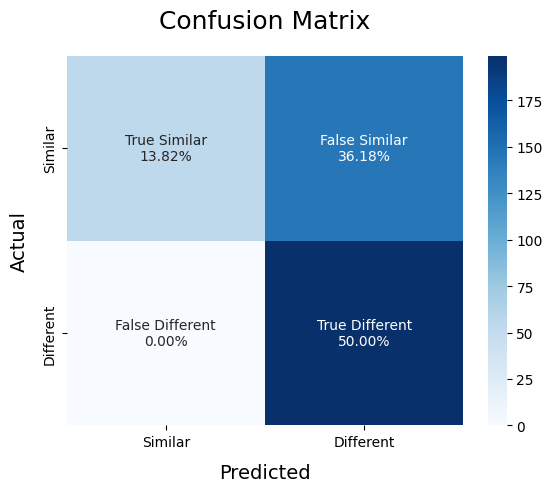

In [ ]:
pos_list = np.array([])
neg_list = np.array([])

for label in test_list.keys():
    label_path = os.path.join("/kaggle/input/face-recognition-dataset/Extracted Faces/Extracted Faces", label)

    # Lấy danh sách các tệp tin ảnh trong thư mục nhãn
    image_files = [f for f in os.listdir(label_path)]

    # Cần ít nhất 2 ảnh để tạo positive pair
    if len(image_files) < 2:
        continue

    # Sắp xếp danh sách ảnh để đảm bảo ảnh đầu và ảnh cuối
    image_files.sort()


    ##### sửa read image
    # Chọn ảnh đầu và ảnh cuối của thư mục
    a = os.path.join(label_path, image_files[0])  # ảnh đầu
    p = os.path.join(label_path, image_files[-1])  # ảnh cuối

    # Lựa chọn một nhãn ngẫu nhiên khác ngoài thư mục hiện tại
    other_label = random.choice([key for key in test_list.keys() if key != label])
    other_label_path = os.path.join("/kaggle/input/face-recognition-dataset/Extracted Faces/Extracted Faces", other_label)
    other_image = os.path.join(other_label_path, random.choice(os.listdir(other_label_path)))  # Lựa chọn ảnh ngẫu nhiên

    pos_list = np.append(pos_list, classify_image(a, p))
    neg_list = np.append(neg_list, classify_image(a, other_image))

ModelMetrics(pos_list, neg_list)

In [ ]:
def create_triplets(directory, folder_list, max_files=15):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets